# Capstone Project - Movie Recommendations for New Users
*Catherine Hocknell* | 10 April, 2023

##### Notebook 1/5

This notebook will detail the intial exploratory data analysis (EDA) and cleaning stages of the *Reviews* dataset, outputting filtered dataframes into new .csv files to be used within the remainder of the notebooks used throughout this project.

---
# Review Data Cleaning

In [3]:
# import all necessary packages

import numpy as np
import pandas as pd

#graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# text analysis
import re
import nltk
import string
from langdetect import detect, DetectorFactory
import contractions #expands contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

#warnings
import warnings
warnings.filterwarnings('ignore')

# 0 Data Import

The data required for this notebook is contained within the following .csv file:

|Filename|Description|
|-|-|
|rotten_tomatoes_critic_reviews.csv|Full reviews dataset from Kaggle|

The file is imported and assigned to a dataframe below.

In [4]:
reviews_df = pd.read_csv('data/rotten_tomatoes_critic_reviews.csv')

# 1 Review Dataset Cleaning
## 1.1 Initial Investigation
First, the reviews dataset is investigated to review its contents and size.

In [5]:
# initial overview
reviews_df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [6]:
# contents
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   rotten_tomatoes_link  1130017 non-null  object
 1   critic_name           1111488 non-null  object
 2   top_critic            1130017 non-null  bool  
 3   publisher_name        1130017 non-null  object
 4   review_type           1130017 non-null  object
 5   review_score          824081 non-null   object
 6   review_date           1130017 non-null  object
 7   review_content        1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB


In [7]:
print(f'The original reviews dataframe has {reviews_df.shape[0]} rows and {reviews_df.shape[1]} columns.')

The original reviews dataframe has 1130017 rows and 8 columns.


In [8]:
reviewers = reviews_df['critic_name'].nunique()
print(f'The original reviews dataframe contains reviews from {reviewers} different reviewers.')

The original reviews dataframe contains reviews from 11108 different reviewers.


The data dictionary for the `reviews_df` dataset is given below.

|Column Name|Description|Data Type|
|-|-|-|
|`rotten_tomatoes_link`|Rotten Tomatoes url link relating to movie|string|
|`critic_name`|Name of critic who rated the movie|string|
|`top_critic`|Boolean value that clarifies whether the critic is a top critic or not|int|
|`publisher_name`|Name of publisher for which critic works|string|
|`review_type`|Status of the review, i.e. either *Fresh* or *Rotten*|string|
|`review_score`|Review score provided by the critic|string|
|`review_date`|Date of the review|string|
|`review_content`|Content of the review|string|

The number of missing values per column is calculated below, along with the percentage contribution of these values within their respective columns.

In [9]:
# sum of missing values per column
reviews_df.isna().sum()

rotten_tomatoes_link         0
critic_name              18529
top_critic                   0
publisher_name               0
review_type                  0
review_score            305936
review_date                  0
review_content           65806
dtype: int64

In [10]:
# percentage of missing values per column
reviews_df.isna().mean()

rotten_tomatoes_link    0.000000
critic_name             0.016397
top_critic              0.000000
publisher_name          0.000000
review_type             0.000000
review_score            0.270736
review_date             0.000000
review_content          0.058235
dtype: float64

The `reviews_df` dataframe contains over **one million** reviews from **11,108** different reviewers, however there are a number of null values contained within some of the key columns. The main columns that are being used within this project are highlighted in the table below.

|Column Name|Use Case|Null Values|
|-|-|-|
|`rotten_tomatoes_link`|Movie ID reference to link to `movies_df`|0|
|`critic_name`|Used to make user based recommendations|18,529 (1.6%)|
|`review_type`|Binary scoring target variable for classification models (Sentiment Analysis)|0|
|`review_score`|Continuous target variable for collaborative recommender system|305,936 (27.1%)|
|`review_content`|Text content for sentiment analysis|65,806 (5.8%)|

As the above table indicates, there is a large amount of missing data within some of these columns, particularly the `review_score` column which is missing **27.1%** of all the possible values. This column will be investigated in more detail to assess how to deal with these missing values, and also to look into its contents as the previous `.info()` function defined the column as a string, which is not expected for a review score value.

## 1.2 Review Score
First, the most common scores used throughout the reviews will be analysed to review the possible contents.

In [11]:
# top 15 most used scores
reviews_df['review_score'].value_counts().head(15)

3/5      90273
4/5      83659
3/4      72366
2/5      60174
2/4      47546
2.5/4    44994
3.5/4    34371
3.5/5    30885
B        24358
5/5      24139
2.5/5    21260
1/5      20709
1.5/4    20475
B+       19822
4/4      18239
Name: review_score, dtype: int64

The above highlight shows that there is a wide range in variety within the `review_score` column, ranging from 'numeric' scores out of four or five, to 'text' scores such as B or B+. In order to use these scores within a recommender system they must be converted to numeric values, which will be very difficult to do for the reviews scored via the 'text' system. For that reason, the numeric calculation will be carried out by splitting this column into a numerator (`num`) and denominator (`denom`) column, which will then themselves be used to calculate an overall percentage score. This is done below, using a copy of the original reviews dataframe.

In [12]:
# create copy of df
rev_copy_df = reviews_df.copy()

# splitting review column in to two nominator and denominator columns
rev_copy_df[['num','denom']] = rev_copy_df['review_score'].str.split('/', expand = True)

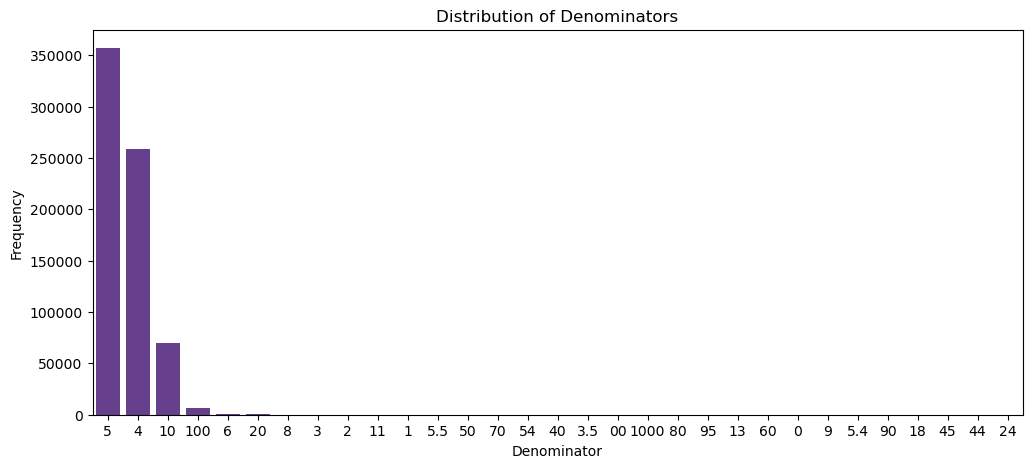

In [13]:
# histogram of reviewer score
plt.figure(figsize = (12,5))

# value counts bar plot of denominator values
sns.barplot(x = rev_copy_df['denom'].value_counts().index, y = rev_copy_df['denom'].value_counts(), color = 'rebeccapurple')

# labels
plt.title('Distribution of Denominators')
plt.xlabel('Denominator')
plt.ylabel('Frequency')


plt.show()

The above shows that a large proportion of the scores are either out of four, five or ten. The dataframe is therefore reduced to only include reviews with these denominator values.

In [14]:
# only where the rating it out of five, four or ten
reduced_df = rev_copy_df[(rev_copy_df['denom']=='5') | (rev_copy_df['denom']=='4') | (rev_copy_df['denom']=='10')]

# sanity check
reduced_df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3.5,5
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...,1,4
7,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ...",3.5,5
9,m/0814255,Jim Schembri,True,The Age (Australia),Fresh,3/5,2010-02-10,"Crammed with dragons, set-destroying fights an...",3,5
10,m/0814255,Mark Adams,False,Daily Mirror (UK),Fresh,4/5,2010-02-10,"This action-packed fantasy adventure, based on...",4,5


In [15]:
# sanity check
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684961 entries, 3 to 1130015
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   rotten_tomatoes_link  684961 non-null  object
 1   critic_name           672998 non-null  object
 2   top_critic            684961 non-null  bool  
 3   publisher_name        684961 non-null  object
 4   review_type           684961 non-null  object
 5   review_score          684961 non-null  object
 6   review_date           684961 non-null  object
 7   review_content        626722 non-null  object
 8   num                   684961 non-null  object
 9   denom                 684961 non-null  object
dtypes: bool(1), object(9)
memory usage: 52.9+ MB


This has reduced the dataframe to now only having around 685,000 reviews. However, the new columns are still saved as strings, so will be converted to numeric values below in order to continue with the calculation of an overall score.

In [16]:
# convert to numeric
reduced_df['num'] = pd.to_numeric(reduced_df['num'])
reduced_df['denom'] = pd.to_numeric(reduced_df['denom'])

With the columns converted, the `final_score` numeric column is calculated below.

In [17]:
# calculate numeric percentage score for each review
reduced_df['final_score'] = reduced_df['num']/reduced_df['denom']

# sanity check
reduced_df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3.5,5,0.70
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...,1.0,4,0.25
7,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ...",3.5,5,0.70
9,m/0814255,Jim Schembri,True,The Age (Australia),Fresh,3/5,2010-02-10,"Crammed with dragons, set-destroying fights an...",3.0,5,0.60
10,m/0814255,Mark Adams,False,Daily Mirror (UK),Fresh,4/5,2010-02-10,"This action-packed fantasy adventure, based on...",4.0,5,0.80


This score can be analysed in more detail by lookin at the statistical information of the numeric columns of the dataframe, which is shown below.

In [32]:
# stats information
reduced_df.describe()

,num,denom,final_score
count,684961.000000,684961.000000,684961.000000
mean,3.241433,5.129564,0.630817
std,1.612336,1.701468,0.215332
min,0.000000,4.000000,0.000000
25%,2.000000,4.000000,0.500000
50%,3.000000,5.000000,0.625000
75%,4.000000,5.000000,0.800000
max,87.000000,10.000000,9.000000


This implies there are obviously some errors within the dataframe, with the maximum final score showing to be 9, which is clearly not a percentage value. It is therefore interesting to look into all the reviews within the dataset which have a numerator value larger than its denominator value, resulting in a score of over 100%. This is shown below.

In [34]:
# error review scores
reduced_df[reduced_df['num'] > reduced_df['denom']]

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score
44843,m/1098652-in_crowd,Scott A. Mantz,False,Scott Mantz' Movie Reviews,Rotten,7/5,2000-01-01,If you're looking for an engaging movie with c...,7.0,5,1.400
111377,m/adoration,Pam Grady,False,Boxoffice Magazine,Fresh,4.5/4,2009-04-23,Egoyan's finest in years.,4.5,4,1.125
112814,m/affliction,Russell Smith,False,Austin Chronicle,Fresh,5.5/5,2000-01-01,NaN,5.5,5,1.100
126588,m/american_beauty,Scott A. Mantz,False,Scott Mantz' Movie Reviews,Fresh,9/5,2000-01-01,You can't help but wonder how people find them...,9.0,5,1.800
190365,m/bless_the_child,Scott A. Mantz,False,Scott Mantz' Movie Reviews,Rotten,8/5,2000-01-01,Considering how jaded moviegoers are these day...,8.0,5,1.600
201589,m/boy_erased,Tiffany Tchobanian,False,Film Threat,Fresh,9.5/5,2018-10-16,Boy Erased is a poignant family drama that exp...,9.5,5,1.900
202512,m/boys_dont_cry,Marjorie Baumgarten,False,Austin Chronicle,Fresh,5.5/5,2000-01-01,NaN,5.5,5,1.100
238191,m/children_of_men,Lawrence Toppman,False,Charlotte Observer,Fresh,35/4,2007-01-04,It's as if Cuaron sees a future so hellish tha...,35.0,4,8.750
238833,m/chill_factor,Scott A. Mantz,False,Scott Mantz' Movie Reviews,Rotten,9/5,2000-01-01,"Cuba, got a minute? We've gotta talk! Your car...",9.0,5,1.800
336986,m/fast_cheap_and_out_of_control,Marjorie Baumgarten,False,Austin Chronicle,Fresh,5.5/5,2000-01-01,NaN,5.5,5,1.100


There are clearly a number of reviews with an inaccurate review score, so these will not be included within the analysis. 

In [126]:
# remove these error values
reduced_df2 = reduced_df[reduced_df['num'] <= reduced_df['denom']]

In [127]:
reduced_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684922 entries, 3 to 1130015
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  684922 non-null  object 
 1   critic_name           672960 non-null  object 
 2   top_critic            684922 non-null  bool   
 3   publisher_name        684922 non-null  object 
 4   review_type           684922 non-null  object 
 5   review_score          684922 non-null  object 
 6   review_date           684922 non-null  object 
 7   review_content        626688 non-null  object 
 8   num                   684922 non-null  float64
 9   denom                 684922 non-null  int64  
 10  final_score           684922 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 58.1+ MB


In [128]:
print(f'The reduced dataset now has {reduced_df2.shape[0]} rows.')

The reduced dataset now has 684922 rows.


In [129]:
# sum of missing values per column
reduced_df2.isna().sum()

rotten_tomatoes_link        0
critic_name             11962
top_critic                  0
publisher_name              0
review_type                 0
review_score                0
review_date                 0
review_content          58234
num                         0
denom                       0
final_score                 0
dtype: int64

There are now no longer any null values related to the review score.

## 1.3 Duplicate and Null Values

The next column containing a large number of missing values is `review_content`. However before dealing with these, duplicate values will be investgated to ensure there are no repeated reviews.

In [130]:
dup = reduced_df2.duplicated().sum()
dup_perc = 100*dup/reduced_df2.shape[0]

print(f'There are {dup} duplicated rows within the dataset, making up {dup_perc:.2f}% of the data.')

There are 72498 duplicated rows within the dataset, making up 10.58% of the data.


10.6% of reviews are showing duplicated information, therefore these will be removed.

In [131]:
# drop the duplicates
reduced_df2= reduced_df2.drop_duplicates()
reduced_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612424 entries, 3 to 1130015
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  612424 non-null  object 
 1   critic_name           601807 non-null  object 
 2   top_critic            612424 non-null  bool   
 3   publisher_name        612424 non-null  object 
 4   review_type           612424 non-null  object 
 5   review_score          612424 non-null  object 
 6   review_date           612424 non-null  object 
 7   review_content        560659 non-null  object 
 8   num                   612424 non-null  float64
 9   denom                 612424 non-null  int64  
 10  final_score           612424 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 52.0+ MB


In [132]:
# count null values per column
reduced_df2.isna().sum()

rotten_tomatoes_link        0
critic_name             10617
top_critic                  0
publisher_name              0
review_type                 0
review_score                0
review_date                 0
review_content          51765
num                         0
denom                       0
final_score                 0
dtype: int64

Even with dropping these null values, **over 50,000 reviews** are missing their text content. As this is the basis of the sentiment analysis and cannot be populated, these will be dropped.

In [133]:
# drop the NaN reviews and save the result to a new variable
clean_df = reduced_df2.drop(reduced_df2[reduced_df2['review_content'].isnull()].index)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560659 entries, 3 to 1130015
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  560659 non-null  object 
 1   critic_name           556271 non-null  object 
 2   top_critic            560659 non-null  bool   
 3   publisher_name        560659 non-null  object 
 4   review_type           560659 non-null  object 
 5   review_score          560659 non-null  object 
 6   review_date           560659 non-null  object 
 7   review_content        560659 non-null  object 
 8   num                   560659 non-null  float64
 9   denom                 560659 non-null  int64  
 10  final_score           560659 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 47.6+ MB


The above information shows the only missing values are now located within the `critic_name` column. These are investigated below.

In [140]:
# analyse critic_name
crit_null = clean_df['critic_name'].isna().sum()
crit_nullp = 100*crit_null/clean_df.shape[0]

print(f'There are {crit_null} null values within the critic_name column, making up {crit_nullp:.2f}% of the data.')

There are 0 null values within the critic_name column, making up 0.00% of the data.


In terms of the Sentiment Analyis, the critic name is not required, so this will be set to 'unknown' for the missing values, as they make up a small percentage of the overall data (0.7%).

In [134]:
# fill null values with 'unknown'
clean_df['critic_name'] = clean_df['critic_name'].fillna('unknown')

In [135]:
print(f'There are now {clean_df.isna().sum().sum()} null values within the reviews dataframe.')

There are now 0 null values within the reviews dataframe.


## 1.4 Review Type
Now that the null values have been assessed, it is also useful to look into the binary target variable column, which in this case is the `review_type` column. This column is investigated below.

In [136]:
# evaluate contents of review_type column
clean_df['review_type'].value_counts()

Fresh     358239
Rotten    202420
Name: review_type, dtype: int64

As expected, this column is made up of only two possible options, so can be converted to a binary (0/1) column using the below relationship:

|Current Value|Binary Value|
|-|-|
|Rotten|0|
|Fresh|1|

In [137]:
# map 'fresh' to 1 and 'rotten' to 0
clean_df['review_type'] = np.where(clean_df['review_type'] == 'Fresh', 1, 0)

#sanity check
clean_df.head(2)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,num,denom,final_score
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),1,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,3.5,5,0.70
6,m/0814255,Nick Schager,False,Slant Magazine,0,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...,1.0,4,0.25


In [138]:
# sanity check
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560659 entries, 3 to 1130015
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   rotten_tomatoes_link  560659 non-null  object 
 1   critic_name           560659 non-null  object 
 2   top_critic            560659 non-null  bool   
 3   publisher_name        560659 non-null  object 
 4   review_type           560659 non-null  int32  
 5   review_score          560659 non-null  object 
 6   review_date           560659 non-null  object 
 7   review_content        560659 non-null  object 
 8   num                   560659 non-null  float64
 9   denom                 560659 non-null  int64  
 10  final_score           560659 non-null  float64
dtypes: bool(1), float64(2), int32(1), int64(1), object(6)
memory usage: 45.4+ MB


In [139]:
# numeric analysis
clean_df.describe()

,review_type,num,denom,final_score
count,560659.000000,560659.000000,560659.000000,560659.000000
mean,0.638961,3.255470,5.126462,0.633907
std,0.480302,1.604836,1.729329,0.211178
min,0.000000,0.000000,4.000000,0.000000
25%,0.000000,2.000000,4.000000,0.500000
50%,1.000000,3.000000,5.000000,0.625000
75%,1.000000,4.000000,5.000000,0.800000
max,1.000000,10.000000,10.000000,1.000000


In [141]:
# print out the shape function to show number of rows and columns within the data
print(f'The current dataset has {clean_df.shape[0]} rows and {clean_df.shape[1]} columns.')

The current dataset has 560659 rows and 11 columns.


The distribution of the two methods of scoring criteria are plotted in a bar chart (`review_type`) and histogram (`final_score`) below.

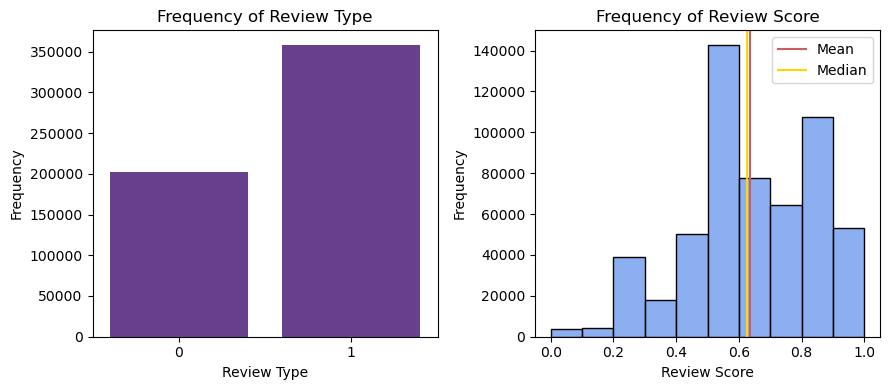

In [142]:
plt.subplots(1,2, figsize = (9,4))

plt.subplot(1,2,1)
# barplot for categorical variables
sns.countplot(x = clean_df['review_type'], color = 'rebeccapurple')
#labels
plt.title('Frequency of Review Type')
plt.xlabel('Review Type')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
# barplot for categorical variables
sns.histplot(x = clean_df['final_score'],bins = 10, color = 'cornflowerblue')
plt.axvline(clean_df['final_score'].mean(), color = 'indianred', label = 'Mean')
plt.axvline(clean_df['final_score'].median(), color = 'gold', label = 'Median')
#labels
plt.title('Frequency of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()

plt.show()

At this stage in the cleaning, the dataframe will be saved as a .csv file to be used in other notebooks as needed.

In [143]:
# print to cleaned_reviews.csv
clean_df.to_csv('data/cleaned_reviews_full.csv')

## 1.5 Review Content
The text data contained within the `review_content` column will now be analysed to ensure it is acceptable for carrying out text analysis. In order to do this, a reduced dataframe containing only the review content and two target variables is created.

In [144]:
# creating a df_text to look into only review and score
df_text = clean_df.loc[:, ['review_content','review_type', 'final_score']]

# sanity check
df_text.head()

,review_content,review_type,final_score
3,Whether audiences will get behind The Lightnin...,1,0.70
6,Harry Potter knockoffs don't come more transpa...,0,0.25
7,"Percy Jackson isn't a great movie, but it's a ...",1,0.70
9,"Crammed with dragons, set-destroying fights an...",1,0.60
10,"This action-packed fantasy adventure, based on...",1,0.80


### 1.5.1. Review Length
The first measurement to look into is the length of the review, which can be calculated by splitting the review into a list and counting the individual words. This is carried out below.

In [145]:
# create lambda function to output the number of individual strings in the review_content column
# i.e. the number of words in the review
df_text['review_length'] = df_text['review_content'].apply(lambda n: len(n.split()))

# sanity check
df_text.head()

,review_content,review_type,final_score,review_length
3,Whether audiences will get behind The Lightnin...,1,0.70,37
6,Harry Potter knockoffs don't come more transpa...,0,0.25,17
7,"Percy Jackson isn't a great movie, but it's a ...",1,0.70,23
9,"Crammed with dragons, set-destroying fights an...",1,0.60,30
10,"This action-packed fantasy adventure, based on...",1,0.80,35


This can be viewed as a histogram below.

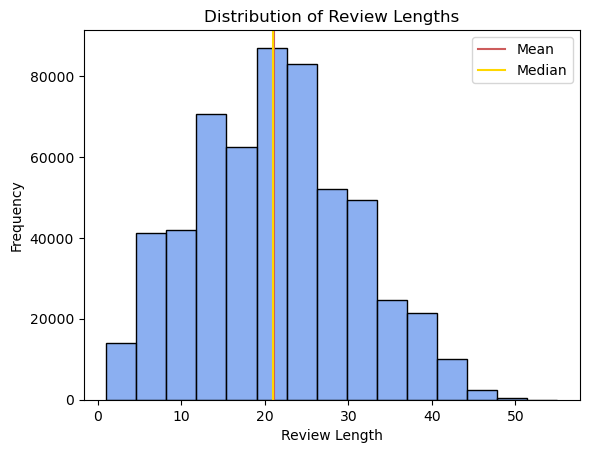

In [146]:
# plot histogram
plt.figure()
sns.histplot(x = df_text['review_length'],bins = 15, color = 'cornflowerblue')
plt.axvline(df_text['review_length'].mean(), color = 'indianred', label = 'Mean')
plt.axvline(df_text['review_length'].median(), color = 'gold', label = 'Median')

# labels
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The review length follows a fairly balanced normal distribution.

### 1.5.2 Text Content
It is now necessary to evaluate the content of the text within these reviews, and remove any rows where the information will not be appropriate for Natural Language Processing (NLP) analysis. The following potential error options will be evaluated and removed:

- No text data (i.e. only numbers or special characters
- Web addresses
- HTML code
- Non-English language reviews

#### 1.5.2.1 No Text Data
First, a regex method will be used to look for any reviews that only contain either special characters or numbers - in otherwords do not contain any words. This is done below.

In [147]:
# regex for continuous string of only numbers \d, special characters \W or whitespace \s (i.e. no text)
df_text['no_text_rev'] = df_text['review_content'].apply(lambda s: bool(re.match('^[\d\W\s]+$',s)))

# sanity check
df_text.head(1)

,review_content,review_type,final_score,review_length,no_text_rev
3,Whether audiences will get behind The Lightnin...,1,0.7,37,False


In this case, any review containing only numbers or special characters has been flagged as 'True'. A count of these values is carried out below, with the table of these reviews then displayed.

In [148]:
# count results for no text data
df_text['no_text_rev'].value_counts()

False    560620
True         39
Name: no_text_rev, dtype: int64

In [149]:
# reviews with no text data
df_text[df_text['no_text_rev']==True]

,review_content,review_type,final_score,review_length,no_text_rev
13908,1.5,0,0.20,1,True
22070,2.5,0,0.40,1,True
138077,2.5,0,0.40,1,True
158117,.,1,1.00,1,True
174986,3.5,1,0.60,1,True
211549,.,0,0.40,1,True
212058,.,0,0.20,1,True
241057,.,1,1.00,1,True
256511,.,1,1.00,1,True
268697,.,1,0.60,1,True


These will not be appropriate for NLP analysis, so will be dropped.

In [150]:
# drop reviews with no text data
df_text.drop(df_text[df_text['no_text_rev']==True].index, inplace = True)

In [151]:
# print out the shape function to show number of rows and columns within the data
print(f'The current review dataset has {df_text.shape[0]} rows.')

The current review dataset has 560620 rows.


#### 1.5.2.2 Web Addresses
Any web address, i.e. containing 'www.', is also not appropriate for NLP analysis. These have been listed below, and are then dropped.

In [152]:
# find reviews containing websites
df_text[df_text['review_content'].str.contains('//www.')]

,review_content,review_type,final_score,review_length,no_text_rev
68567,"Intelligent, intricate thriller. http://www.de...",1,0.600,4,False
79388,Rahim and Arestrup are both so outstanding tha...,1,0.800,24,False
145053,Argott treats Barnes' story as an intellectual...,1,0.600,29,False
222343,http://www.spiritualityandpractice.com/films/r...,1,0.600,1,False
352142,http://www.totalfilm.com/cinema_reviews/films_...,0,0.400,1,False
456005,"Cassel is a gifted actor, but he doesn't have ...",0,0.625,17,False
730367,http://www.commonsensemedia.org/movie-reviews/...,1,0.800,1,False
974730,https://www.commonsensemedia.org/movie-reviews...,1,0.600,1,False
981550,http://www.thisislondon.co.uk/film/film-233392...,1,0.600,1,False


In [153]:
# drop reviews containing websites
df_text.drop(df_text[df_text['review_content'].str.contains('//www.')].index, inplace = True)

In [154]:
# print out the shape function to show number of rows and columns within the data
print(f'The current review dataset has {df_text.shape[0]} rows.')

The current review dataset has 560611 rows.


#### 1.5.2.3 HTML code
Next, regex is used again to assess if there are any reviews containing any HTML code - i.e. \<text\>. These are evaluated below.

In [155]:
# check for any occurrance of < and >
df_text['no_html'] = df_text['review_content'].apply(lambda h: bool(re.match(r'<.*?>',h)))

# outcome of regex investigation
df_text['no_html'].value_counts()

False    560611
Name: no_html, dtype: int64

The above shows that there is no HTML code contained within any of the reviews in the dataset.

In [156]:
# print out the shape function to show number of rows and columns within the data
print(f'The current review dataset has {df_text.shape[0]} rows.')

The current review dataset has 560611 rows.


In [157]:
df_text.to_csv('data/languages_full.csv')

#### 1.5.2.4 Language Analysis
Finally, `spacy` is used to analyse the language of each of the reviews. This is a package which also provides a probability score for the language that has been detected, however can take a very long time to run over such a large dataset. The methodology that has been carried out is shown below, however the languages.csv result file has been imported in as this was done within a different notebook.

---

In [33]:
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)

# assign spacy model
nlp_model = spacy.load("en_core_web_sm")

# define language detector from spacy
Language.factory("language_detector", func=get_lang_detector)

# include language detector within nlp model
nlp_model.add_pipe('language_detector', last=True)

In [ ]:
lang = [] # language list
lang_score = [] # language score list

# loop through each review
for index, row in df_text['review_content'].iteritems():
    # assign language output from nlp model to lang list
    lang = nlp_model(row)._.language['language']
    # assign language score to score list
    lang_score = nlp_model(row)._.language['score']
    
    # populate df text with the language and score in the correct index location
    df_text.loc[index,'Language'] = lang
    df_text.loc[index,'Language_Score'] = lang_score

In [ ]:
df_text.to_csv('data/languages.csv')

---

In [159]:
# output from language detection
df_languages = pd.read_csv('data/languages_complete.csv', index_col=0)
df_languages.head()

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score
3,Whether audiences will get behind The Lightnin...,1,0.70,37,False,False,en,0.999996
6,Harry Potter knockoffs don't come more transpa...,0,0.25,17,False,False,en,0.999998
7,"Percy Jackson isn't a great movie, but it's a ...",1,0.70,23,False,False,en,0.999998
9,"Crammed with dragons, set-destroying fights an...",1,0.60,30,False,False,en,0.999997
10,"This action-packed fantasy adventure, based on...",1,0.80,35,False,False,en,0.999998


Essential to confirm that this table includes the same number of rows as the previous `df_text` dataframe.

In [160]:
print(f'The translated dataframe contains {df_languages.shape[0]} rows and {df_languages.shape[1]} columns.')
print(f'The original text dataframe contains {df_text.shape[0]} rows and {df_text.shape[1]} columns.')

The translated dataframe contains 560611 rows and 8 columns.
The original text dataframe contains 560611 rows and 6 columns.


In [161]:
# sanity check for the content
df_text.head()

,review_content,review_type,final_score,review_length,no_text_rev,no_html
3,Whether audiences will get behind The Lightnin...,1,0.70,37,False,False
6,Harry Potter knockoffs don't come more transpa...,0,0.25,17,False,False
7,"Percy Jackson isn't a great movie, but it's a ...",1,0.70,23,False,False
9,"Crammed with dragons, set-destroying fights an...",1,0.60,30,False,False
10,"This action-packed fantasy adventure, based on...",1,0.80,35,False,False


These two dataframes can now be joined together on the movie index to have a fully populated table showing all the necessary text information.

In [162]:
# create new df that adds on the 'language' and 'language_Score' columns from the imported csv 
full_df = pd.concat([df_text, df_languages[['Language', 'Language_Score']]], axis=1, join = 'inner')

# sanity check
full_df.head()

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score
3,Whether audiences will get behind The Lightnin...,1,0.70,37,False,False,en,0.999996
6,Harry Potter knockoffs don't come more transpa...,0,0.25,17,False,False,en,0.999998
7,"Percy Jackson isn't a great movie, but it's a ...",1,0.70,23,False,False,en,0.999998
9,"Crammed with dragons, set-destroying fights an...",1,0.60,30,False,False,en,0.999997
10,"This action-packed fantasy adventure, based on...",1,0.80,35,False,False,en,0.999998


In [163]:
print(f'The full text dataframe contains {full_df.shape[0]} rows and {full_df.shape[1]} columns.')

The full text dataframe contains 560611 rows and 8 columns.


This dataframe can now be filtered to remove any reviews that have not been detected as being in English. For initial investigation, the counts of each of the detected languages is shown below.

In [165]:
full_df.Language.value_counts()

en         550782
pt           2041
es           1317
fr           1093
no            618
af            593
ro            475
it            465
da            464
nl            404
cy            348
ca            326
tl            318
de            294
et            147
id            143
hr            119
sv            114
so            108
lt             93
fi             90
pl             51
hu             40
sk             36
tr             28
sq             25
sl             24
vi             16
cs             15
sw             13
lv              6
el              4
UNKNOWN         1
Name: Language, dtype: int64

The above output shows that a large proportion of the reviews within the dataset are in fact in english. At this stage, all other languages will be removed, and the information within the remaining rows will be assessed further, looking specifically at the `Language_Score` column.

In [166]:
# only concerned with reviews in english
english_df = full_df[full_df['Language']=='en']

# sanity check
english_df.head()

,review_content,review_type,final_score,review_length,no_text_rev,no_html,Language,Language_Score
3,Whether audiences will get behind The Lightnin...,1,0.70,37,False,False,en,0.999996
6,Harry Potter knockoffs don't come more transpa...,0,0.25,17,False,False,en,0.999998
7,"Percy Jackson isn't a great movie, but it's a ...",1,0.70,23,False,False,en,0.999998
9,"Crammed with dragons, set-destroying fights an...",1,0.60,30,False,False,en,0.999997
10,"This action-packed fantasy adventure, based on...",1,0.80,35,False,False,en,0.999998


In [167]:
# review numeric data
english_df.describe()

,review_type,final_score,review_length,Language_Score
count,550782.000000,550782.000000,550782.000000,550782.000000
mean,0.639342,0.634055,21.263703,0.996420
std,0.480192,0.210589,9.301982,0.031770
min,0.000000,0.000000,1.000000,0.285713
25%,0.000000,0.500000,14.000000,0.999996
50%,1.000000,0.625000,21.000000,0.999997
75%,1.000000,0.800000,28.000000,0.999998
max,1.000000,1.000000,55.000000,1.000000


Most of the reviews have a very high score for en (i.e. English), which is indicated by the mean and median both being over 0.99. However, the minimum score is 0.286, indicating that this may not be a review with purely english words. Reviews with a low score are investigated below.

In [168]:
# evaluating language scores
eng99 = english_df[english_df['Language_Score'] < 0.99].shape[0]
eng99_per = 100* eng99/english_df.shape[0]

print(f'There are {eng99} reviews with a language score below 99%, making up {eng99_per:.2f}% of the data.')

There are 8845 reviews with a language score below 99%, making up 1.61% of the data.


Only 1.6% of all the rows within the dataset have a `Language_Score` of less than 0.99. This is considered to be a measure that implies that the review is fully in english, meaning that all the values above this measure can be assumed as appropriate for modelling. As 1.6% is a low proportion of the dataset, these rows have been removed for the full analysis.

In [169]:
# drop scores below 99% for final dataset
final_df = english_df[english_df['Language_Score'] >= 0.99]

In [170]:
print(f'The fully cleaned review dataset has {final_df.shape[0]} rows.')

The fully cleaned review dataset has 541937 rows.


The review dataset has now been fully cleaned, so this is saved to a new .csv file to be used within the *Data Wrangling* notebook later.

In [171]:
# output csv file to data folder
final_df.to_csv('data/english_reviews_full.csv')

# 2 Next Steps
The *english_reviews_full.csv* file generated from this notebook will now be used within the *Data Wrangling* notbook to carry out some initial NLP processing and other data wrangling before carrying out the Sentiment Analysis and Recommender System generation.

---